## Lab 3: Anomaly Detection 1

In this lab, you will be working with detecting anomalies in data. You will use basic Python libraries and the PyOD (https://pyod.readthedocs.io/en/latest/) library for detecting anomalies. Save your implementations with the name 'lab2_yourname.ipynb' and submit by the due date.

In [4]:
pip install pyod

  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185349 sha256=c6d0580bd0a4ab5fc505731126f22e14ff0982e149b2c1fbd9fa44b3f76df3a1
  Stored in directory: c:\users\nkill\appdata\local\pip\cache\wheels\d7\21\ce\d0f4083609d89f6c4371a5ecb8c13636e7570abaed1e2473ce
Successfully built pyod
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option("display.max_columns",100)
from pyod.utils.example import visualize
from pyod.utils.data import evaluate_print

## Data overview

This dataset contains information on variants of the French wine. The dataset contains information on physicochemical variables that were recorded on different wine samples.

There 6497 datapoints and twelve variables, namely: fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates, alcohol level and quality.


In [2]:
wine_data= pd.read_excel('wine_data.xls')
wine_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [3]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 609.2 KB


Lets engineer a new feature 'score' that assigns values to the wine samples based on the quality.

In [4]:
#New feature
wine_data['score'] = [1 if x >= 5 else 0 for x in wine_data['quality']]


In [5]:
#For simplicity, we will now filter the dataset to a few features
wine_filtered=wine_data[['fixed acidity','volatile acidity', 'score']]

<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### Data visualization as a tool for anomaly detection

</div>

The simplest way to detect any anomalies or outliers in your dataset is to plot the data to identify any outlier patterns. 
In the example below, we implement a boxplot on feature: fixed acidity and a histogram on feature: volatile acidity to check for outliers.

{'whiskers': [<matplotlib.lines.Line2D at 0x1dc11d84430>,
 'caps': [<matplotlib.lines.Line2D at 0x1dc11d84a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dc11d84280>],
 'medians': [<matplotlib.lines.Line2D at 0x1dc11d84f70>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dc11d99280>],
 'means': []}

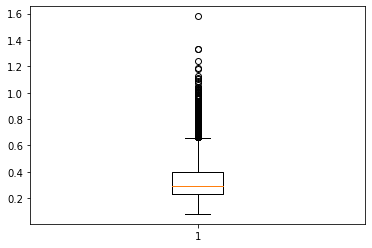

In [6]:
plt.boxplot(wine_filtered['volatile acidity'])

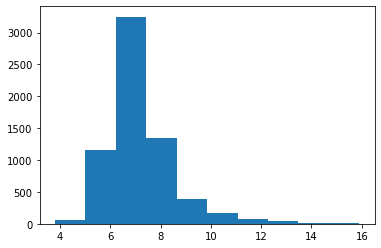

In [7]:
plt.hist(wine_filtered['fixed acidity'])
hist, bin_edges=np.histogram(wine_filtered['fixed acidity'].to_numpy(), density=False, bins=2)

<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### PyOD for anomaly detection

</div>


## Data Preparation


In [8]:
#we will use the 'score' as the labels and assign 'fixed acidity' and 'volatile acidity' as the features
labels=wine_filtered['score']
data=wine_filtered[['fixed acidity','volatile acidity']]

In [9]:
#we will use the standardizer from the PyOD library
from pyod.utils.utility import standardizer
data_std=standardizer(data)

In [10]:
#split percentage
split = int(0.7 * len(data))

train_data = data_std[:split]
test_data= data_std[split:]
train_labels= labels[:split]
test_labels=labels[split:]

<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### Multivariate Methods

</div>

## HBOS

The idea behind HBOS is to construct a histogram of the data for each dimension and calculate a score for how likely it is for a datapoint to fall within the histogram bins for each dimension. 

It is important to note that HBOS from PyOD is sensitive to the number of bins selected for the histograms.In the example below, we implement HBOS on our data with the number of bins set to 3 and observe the results.


On Training Data:
HBOS ROC:0.3953, precision @ rank n:0.9343

On Test Data:
HBOS ROC:0.3606, precision @ rank n:0.7949


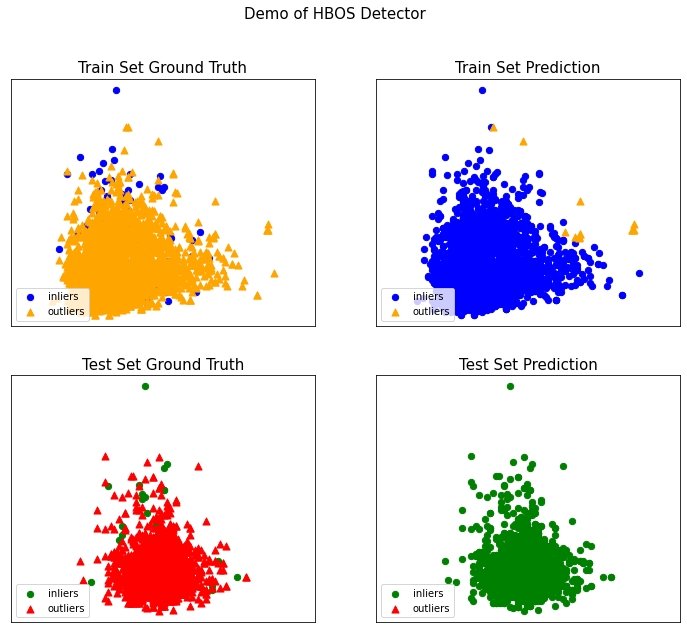

In [11]:
from pyod.models.hbos import HBOS


clf_hb=HBOS(n_bins=3, contamination=0.0367)
clf_hb.fit(train_data)

# get the prediction labels and outlier scores of the training data
train_pred_hb = clf_hb.labels_  # binary labels (0: inliers, 1: outliers)
train_scores_hb = clf_hb.decision_scores_  # raw outlier scores

# get the prediction on the test data
test_pred_hb = clf_hb.predict(test_data)  # outlier labels (0 or 1)
test_scores_hb = clf_hb.decision_function(test_data)  # outlier scores



# evaluate and print the results
print("\nOn Training Data:")
evaluate_print('HBOS', train_labels, train_scores_hb)
print("\nOn Test Data:")
evaluate_print('HBOS', test_labels, test_scores_hb)

visualize('HBOS', train_data, train_labels, test_data, test_labels, train_pred_hb, test_pred_hb, show_figure=True, save_figure=False)



<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 1

### Experiment with different values for the number of bins to see if you can increase the ROC score >= 0.75. 


</div>

In [12]:
from pyod.models.hbos import HBOS
from sklearn.metrics import roc_auc_score

# List of different number of bins to experiment with
num_bins_list = [3, 5, 7, 10, 15]

for num_bins in num_bins_list:
    # Create and fit the HBOS model with the current number of bins
    clf_hb = HBOS(n_bins=num_bins, contamination=0.0367)
    clf_hb.fit(train_data)

    # Get the outlier scores on the test data
    test_scores_hb = clf_hb.decision_function(test_data)  # outlier scores

    # Calculate the ROC score for each experiment
    roc_score = roc_auc_score(test_labels, test_scores_hb)
    print(f"Number of Bins = {num_bins}: ROC Score = {roc_score}")


Number of Bins = 3: ROC Score = 0.360627583691335
Number of Bins = 5: ROC Score = 0.38847572343357384
Number of Bins = 7: ROC Score = 0.3723048553132852
Number of Bins = 10: ROC Score = 0.39248804409499877
Number of Bins = 15: ROC Score = 0.40907432925346515


<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### Neighbourhood-based Methods

</div>

Neighbourhood based methods try to detect various types of multivariate outliers by considering neighbourhoods of datapoints.

## KNN

<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 2

### Implement KNN with the pyod library. Use the Euclidean distance as the metric, and the average distance of the neighbours. Experiment with different values for n_neighbours. 

### Hint: https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.knn



</div>

In [13]:
#Please implement Task 2 here
from pyod.models.knn import KNN
from sklearn.metrics import roc_auc_score

# List of different values for n_neighbors to experiment with
n_neighbors_list = [3, 5, 7, 10, 15]

for n_neighbors in n_neighbors_list:
    # Create and fit the KNN model with the current number of neighbors
    clf_knn = KNN(n_neighbors=n_neighbors, method='mean', metric='euclidean')
    clf_knn.fit(train_data)

    # Get the outlier scores on the test data
    test_scores_knn = clf_knn.decision_function(test_data)  # outlier scores

    # Calculate the ROC score for each experiment
    roc_score = roc_auc_score(test_labels, test_scores_knn)
    print(f"n_neighbors = {n_neighbors}: ROC Score = {roc_score}")


n_neighbors = 3: ROC Score = 0.3544621869174029
n_neighbors = 5: ROC Score = 0.33064663208235395
n_neighbors = 7: ROC Score = 0.3383470454729675
n_neighbors = 10: ROC Score = 0.3478408446137635
n_neighbors = 15: ROC Score = 0.3524002999108374


## LOF or COF

<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 3

### Take a look at the scatterplot of the dataset with our two feature fixed acidity and volatile acidity. Determine whether we should use LOF or COF on the dataset and implement it. Give a reason for your choice?


### Hint: Use functions from the PyOD library



</div>

<img src="images/scatter.png" alt="Alternative text" />

In [16]:
#Please implement Task 3 here
from pyod.models.lof import LOF


# LOF:
clf = LOF(contamination=0.0367, n_neighbors=10)
clf.fit(train_data)
test_scores = clf.decision_function(test_data)

# Evaluate the model's performance (e.g., ROC score)
roc_score = roc_auc_score(test_labels, test_scores)
print(f"ROC Score: {roc_score}")


ROC Score: 0.4868383723757802


In [ ]:
'''
we chose LOF because we see points that have score zero in the dense area or close to.
If we observe clusters or varying densities in the scatterplot, LOF may be a suitable choice. 
LOF is effective at detecting outliers in regions with varying data densities.
'''

<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### One-class classification based Methods

</div>

One-class classification based methods detect anomalies by finding a region of space where the majority of data samples reside with the highest density.

## One-class SVM

<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 4

### Implement OCSVM with a linear or non-linear kernel of your choice.

   
### Hint: Use functions from the PyOD library https://pyod.readthedocs.io/en/latest/_modules/pyod/models/ocsvm.html



</div>

In [17]:
#Please implement Task 4 here
from pyod.models.ocsvm import OCSVM
from sklearn.metrics import roc_auc_score

# linear kernel:
clf_ocsvm = OCSVM(kernel='linear', nu=0.0367)

# Fit the model on the training data
clf_ocsvm.fit(train_data)

# Get the outlier scores on the test data
test_scores_ocsvm = clf_ocsvm.decision_function(test_data)

# Evaluate the model's performance (e.g., ROC score)
roc_score = roc_auc_score(test_labels, test_scores_ocsvm)
print(f"ROC Score: {roc_score}")


ROC Score: 0.6118434384372213


<div class='alert alert-block alert-warning' style="font-weight:bolder">
 
 ### Clustering-based Methods

</div>

Clustering-based approaches assume that normal data belongs to large and dense clusters while, anomalies either do not belong to any of the clusters or form very small clusters.

<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 5

### Implement DBSCAN on the dataset. Experiment with 2 different values for epsilon and minpts. Report your results below. Which hyperparameter values give you better results??


Please note that we will use the sklearn version (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

</div>

In [22]:
#Please implement Task 5 here
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# List of different values for epsilon (eps) and minimum points (min_samples) to experiment with
eps_values = [0.3, 0.5]
min_samples_values = [5, 10]

best_eps = None
best_min_samples = None
best_silhouette_score = -1  # Initialize with a low value

# Iterate through different combinations of eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        # Create a DBSCAN model with the current hyperparameters
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit the model to the dataset
        labels = dbscan.fit_predict(train_data)

        # Calculate the silhouette score to evaluate the clustering quality
        silhouette_avg = silhouette_score(train_data, labels)

        # Report the results for the current hyperparameters
        print(f"eps={eps}, min_samples={min_samples}: Silhouette Score = {silhouette_avg}")

        # Update the best hyperparameters if the current score is better
        if silhouette_avg > best_silhouette_score:
            best_eps = eps
            best_min_samples = min_samples
            best_silhouette_score = silhouette_avg

# Report the best hyperparameter values and the corresponding silhouette score
print(f"Best hyperparameters: eps={best_eps}, min_samples={best_min_samples}")
print(f"Best Silhouette Score = {best_silhouette_score}")


eps=0.3, min_samples=5: Silhouette Score = 0.29612153634701477
eps=0.3, min_samples=10: Silhouette Score = 0.49954138473952325
eps=0.5, min_samples=5: Silhouette Score = 0.6449835648211775
eps=0.5, min_samples=10: Silhouette Score = 0.6366415269989067
Best hyperparameters: eps=0.5, min_samples=5
Best Silhouette Score = 0.6449835648211775


<div class='alert alert-block alert-success' style="font-weight:bolder">
    
### Task 6

### Compare the results from HBOS, One-class SVM, LOF or COF and KNN. Which one performed better? Can you think of any reasons why?.
    
</div>

### Write your answer to task 6 here.

In [ ]:
'''
One-Class SVM (OCSVM) appears to have performed the best, followed by DBSCAN.

reasons could be why:
OCSVM can capture non-linear patterns effectively, making it suitable for datasets with complex relationships. 
It has found a good balance between precision and recall, leading to a high ROC score.

DBSCAN: DBSCAN is effective when there are clusters or varying densities in the data. 
It has identified clusters well, and anomalies are points that do not belong to any cluster. 
In this case, DBSCAN has found a good separation between clusters, leading to a high silhouette score.
'''